In [61]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log', 'time', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [62]:
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

import tensorflow as tf
import numpy as np
import os
import fnmatch
import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn import manifold, datasets
from sklearn import feature_selection

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from time import time

import seaborn as sns

COMET WARNING: We detected that you are running inside a Ipython/Jupyter notebook environment but we cannot save your notebook source code. Please be sure to have installed comet_ml as a notebook server extension by running:
jupyter comet_ml enable
COMET INFO: old comet version (1.0.9) detected. current: 1.0.16 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Comet.ml support for Ipython Notebook is limited at the moment, automatic monitoring and stdout capturing is deactivated
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/incnas/general/14823d7681524afda4982f7dc79a05b4



In [63]:
from shutil import copyfile
import scipy.misc

In [64]:
sns.set(style="white")

## Load Data

In [65]:
path = "data\\sorted\\agg\\ids.csv"
root_dir = "data\\sorted\\agg\\"

In [66]:
data = pd.read_csv(path, index_col=0)
data = data[~data['name'].str.contains("_flipped")]

In [67]:
data = data.sample(frac=1)

In [68]:
data.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks,sd,num_local_peaks
17,17,2017.11.09,3600,chip3_08heightmap.mat,16.551449,8183,51506.323805,0.981831,1,0.165313,6.294308,[[8.18300000e+03 1.90493700e+06 5.90920801e+08...,-1.461690,838.440692,[[ 864.75809724 -1902.15362956]\r\n [-1902.15...,0,3,2.593481,10
113,113,2017.11.22,7200,17.20 s.tifheightmap.mat,7.070157,4943,19488.273277,0.947413,1,0.500304,3.942600,[[4.94300000e+03 3.75758000e+05 3.47047160e+07...,1.287345,369.261977,[[ 230.61349172 321.9956515 ]\r\n [ 321.99565...,2,1,2.139502,7
199,199,2017.11.23,7200,41.40 s.tifheightmap.mat,14.079092,18185,154263.709168,0.967704,1,0.180762,8.483019,[[1.81850000e+04 3.95751200e+06 1.20851626e+09...,-1.195421,1060.381818,[[ 4138.00270981 -6977.9321863 ]\r\n [-6977.93...,0,2,3.404156,16
7,7,2017.11.09,1800,chip2_10heightmap.mat,11.378425,8118,27872.625418,0.935990,1,0.380573,3.433435,[[8.11800000e+03 1.10605500e+06 1.83092763e+08...,1.450962,864.884343,[[ 551.39529366 420.21367739]\r\n [ 420.21367...,2,2,2.092512,9
187,187,2017.11.23,7200,14.20 s.tifheightmap.mat,9.282661,2276,12150.283870,0.987456,1,0.692214,5.338438,[[2.27600000e+03 1.48020000e+05 1.25202880e+07...,1.559568,304.367532,[[ 31.85684096 13.92068609]\r\n [ 13.92068...,0,1,2.823234,1


In [69]:
donor = data['date']
samples = data.drop(columns=['name','date','source','moments','orientation','inertia_tensor'])
train_data = samples.drop(columns=['flow_rate'])

In [70]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 17 to 176
Data columns (total 13 columns):
flow_rate          201 non-null int64
peak_val           201 non-null float64
area               201 non-null int64
volume             201 non-null float64
eccentricity       201 non-null float64
euler_number       201 non-null int64
extent             201 non-null float64
mean_intensity     201 non-null float64
perimeter          201 non-null float64
cluster            201 non-null int64
num_peaks          201 non-null int64
sd                 201 non-null float64
num_local_peaks    201 non-null int64
dtypes: float64(7), int64(6)
memory usage: 22.0 KB


In [71]:
points = train_data.as_matrix()
normalized = preprocessing.Normalizer().fit_transform(points)
standardize = preprocessing.scale(points)

df_standardize = preprocessing.scale(samples.as_matrix())
df_normalize = preprocessing.Normalizer().fit_transform(samples.as_matrix())
df_raw = samples.as_matrix()

In [72]:
normalized.shape

(201, 12)

## Data Analysis

## Visualisations:

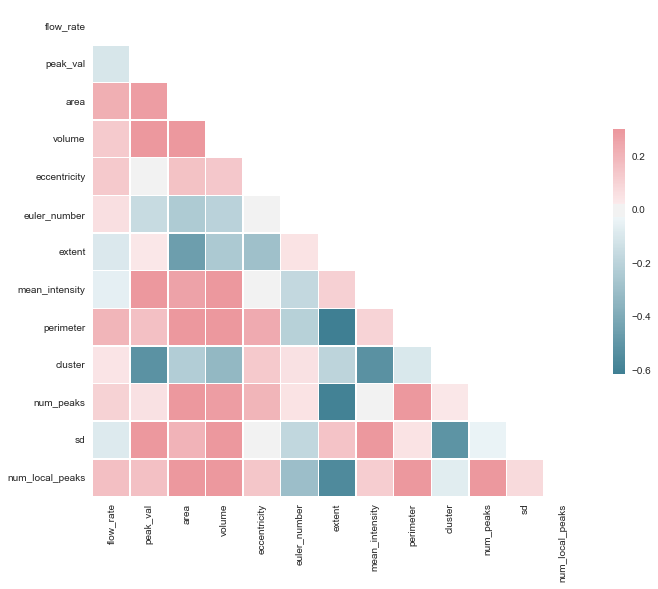

In [73]:
# Generate a large random dataset
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 #columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = pd.DataFrame(data=df_raw,columns=list(samples)).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [74]:
donor_count = donor.value_counts()

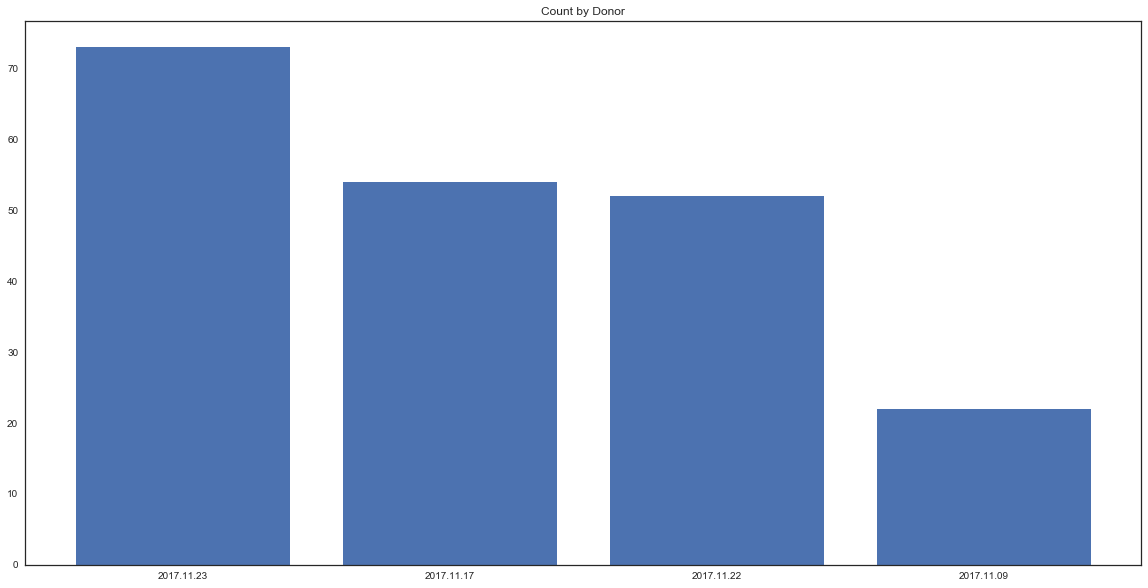

In [75]:
t = data[data['flow_rate']==1800]
u = data[data['flow_rate']==3600]
v = data[data['flow_rate']==7200]

a = data[data['cluster']==0]
b = data[data['cluster']==1]
c = data[data['cluster']==2]

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Peaks by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')

plt.subplot(121)
plt.title("Num Peaks by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')'''

#plt.subplot(121)
#plt.title("Count by Cluster")
#plt.hist(donor_count.values, bins=4)

#fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(formatter)

x = np.arange(4)
#plt.subplot(121)
plt.title("Count by Donor")
plt.bar(x, donor_count.values)
plt.xticks(x, donor_count.index)
plt.show()

plt.show()

Number of different blobs as identified by Otsu's

Num Peaks by Donor: 
2017.11.23: 1    65
2     7
3     1
Name: num_peaks, dtype: int64
2017.11.17: 1    46
2     7
3     1
Name: num_peaks, dtype: int64
2017.11.22: 1    44
2     8
Name: num_peaks, dtype: int64
2017.11.09: 1    17
2     3
3     2
Name: num_peaks, dtype: int64
Num Peaks by Flow Rate: 
1800: [59, 7, 0]
3600: [66, 9, 2]
7200: [47, 9, 2]


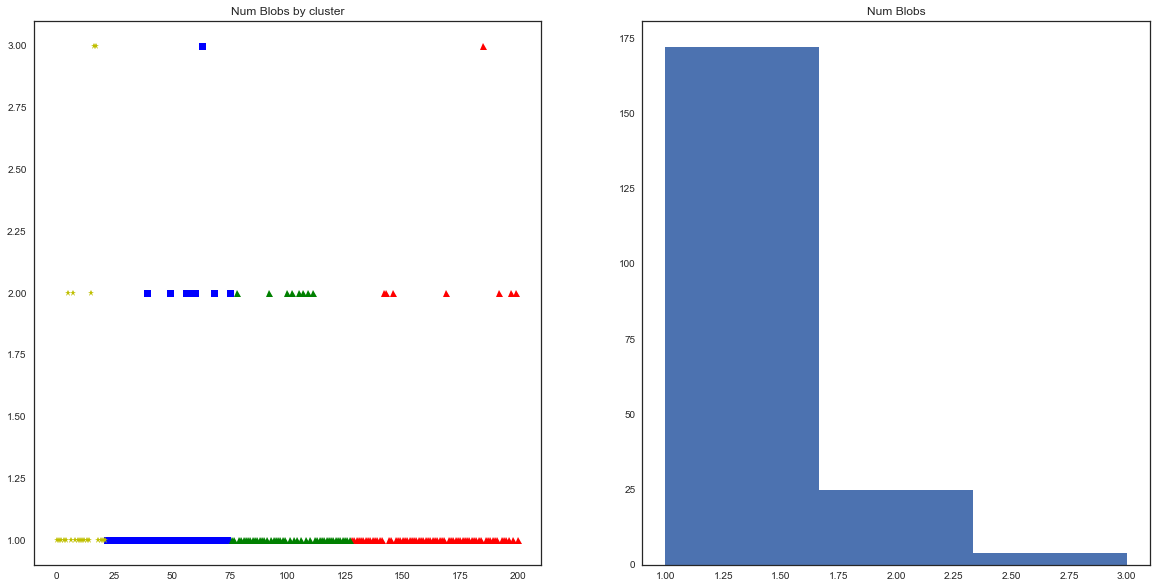

In [76]:
t = data[data['date']=='2017.11.23']['num_peaks']
u = data[data['date']=='2017.11.17']['num_peaks']
v = data[data['date']=='2017.11.22']['num_peaks']
w = data[data['date']=='2017.11.09']['num_peaks']

print("Num Peaks by Donor: ")
print("2017.11.23: " + str(t.value_counts()))
print("2017.11.17: " + str(u.value_counts()))
print("2017.11.22: " + str(v.value_counts()))
print("2017.11.09: " + str(w.value_counts()))

N = 4

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

a = data[data['flow_rate']==1800]
a = a.groupby('num_peaks').size().tolist()
a.append(0)

b = data[data['flow_rate']==3600]
b = b.groupby('num_peaks').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('num_peaks').size().tolist()

print("Num Peaks by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Blobs by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')'''

plt.subplot(121)
plt.title("Num Blobs by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.subplot(122)
plt.title("Num Blobs")
plt.hist(data['num_peaks'], bins=3)

plt.show()

Peak Value of each image

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


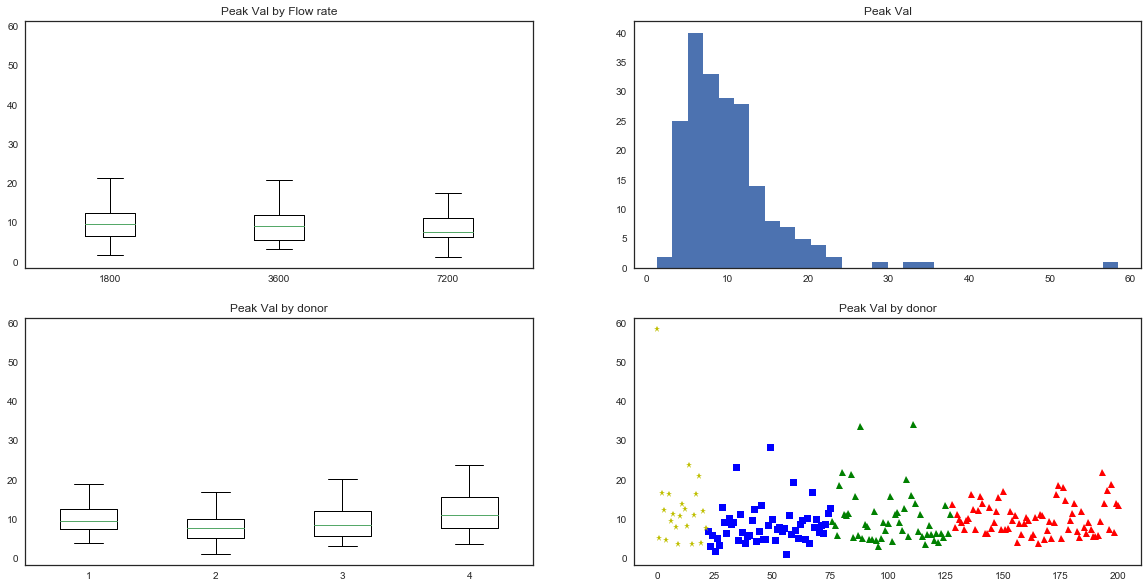

In [77]:
t = data[data['date']=='2017.11.23']['peak_val']
u = data[data['date']=='2017.11.17']['peak_val']
v = data[data['date']=='2017.11.22']['peak_val']
w = data[data['date']=='2017.11.09']['peak_val']

a = data[data['flow_rate']==1800]['peak_val']
b = data[data['flow_rate']==3600]['peak_val']
c = data[data['flow_rate']==7200]['peak_val']

# red dashes, blue squares and green triangles
#plt.plot(data[data['cluster']==0]['peak_val'], t, 'r--', u, u, 'bs', v, v, 'g^')
plt.subplot(221)
plt.title("Peak Val by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Peak Val")
plt.hist(data['peak_val'], bins=30)

plt.subplot(223)
plt.title("Peak Val by donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Peak Val by donor")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


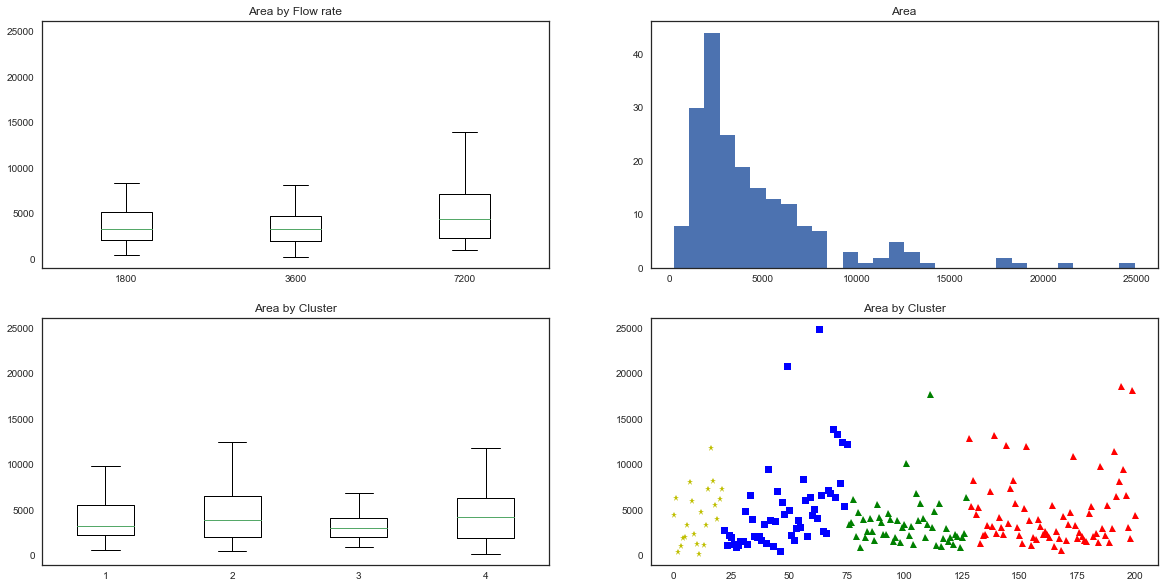

In [78]:
t = data[data['date']=='2017.11.23']['area']
u = data[data['date']=='2017.11.17']['area']
v = data[data['date']=='2017.11.22']['area']
w = data[data['date']=='2017.11.09']['area']

a = data[data['flow_rate']==1800]['area']
b = data[data['flow_rate']==3600]['area']
c = data[data['flow_rate']==7200]['area']

# red dashes, blue squares and green triangles
#plt.plot(data[data['cluster']==0]['peak_val'], t, 'r--', u, u, 'bs', v, v, 'g^')
plt.subplot(221)
plt.title("Area by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Area")
plt.hist(data['area'], bins=30)

plt.subplot(223)
plt.title("Area by Cluster")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Area by Cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


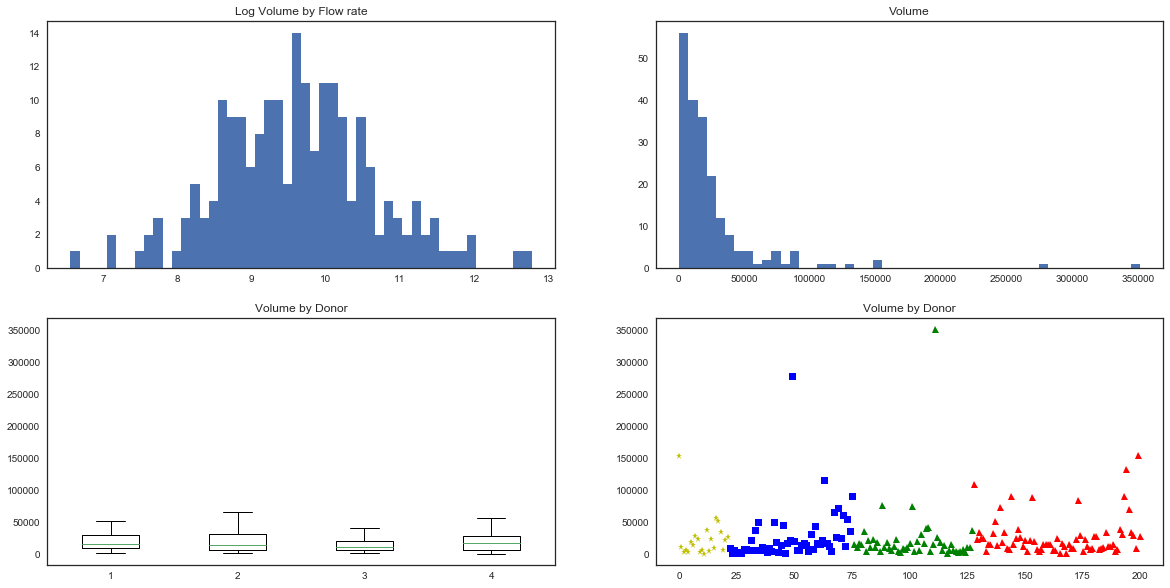

In [79]:
t = data[data['date']=='2017.11.23']['volume']
u = data[data['date']=='2017.11.17']['volume']
v = data[data['date']=='2017.11.22']['volume']
w = data[data['date']=='2017.11.09']['volume']

a = data[data['flow_rate']==1800]['volume']
b = data[data['flow_rate']==3600]['volume']
c = data[data['flow_rate']==7200]['volume']

log = data['volume'].apply(np.log)

plt.subplot(221)
plt.title("Log Volume by Flow rate")
#plt.boxplot([a,b,c], labels=['1800','3600','7200'])
plt.hist(log, bins=50)

plt.subplot(222)
plt.title("Volume")
plt.hist(data['volume'], bins=50)

plt.subplot(223)
plt.title("Volume by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Volume by Donor")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


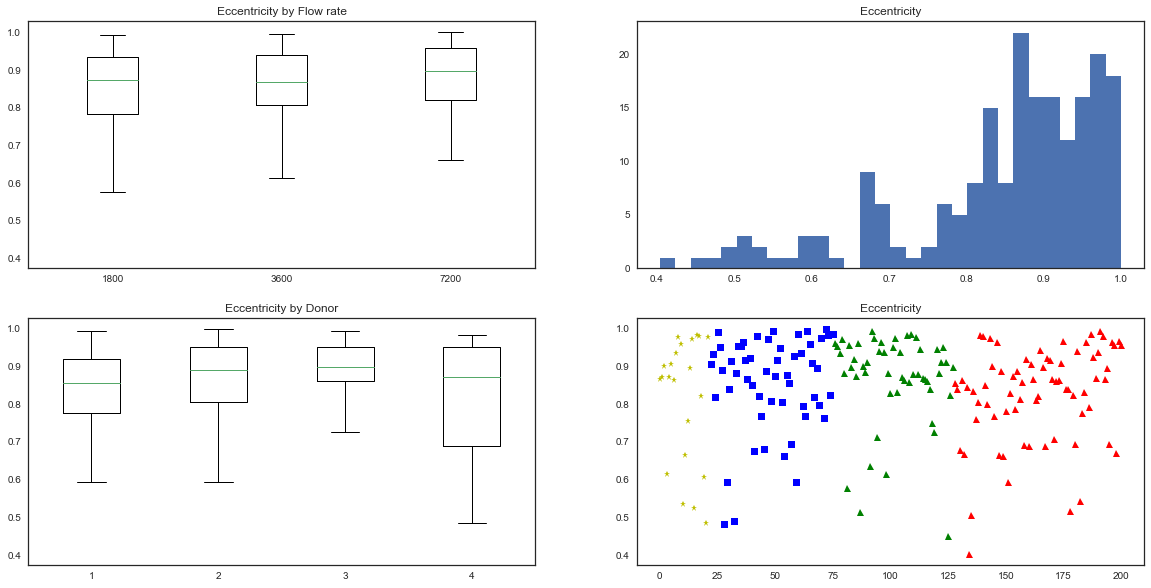

In [80]:
t = data[data['date']=='2017.11.23']['eccentricity']
u = data[data['date']=='2017.11.17']['eccentricity']
v = data[data['date']=='2017.11.22']['eccentricity']
w = data[data['date']=='2017.11.09']['eccentricity']

a = data[data['flow_rate']==1800]['eccentricity']
b = data[data['flow_rate']==3600]['eccentricity']
c = data[data['flow_rate']==7200]['eccentricity']

plt.subplot(221)
plt.title("Eccentricity by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Eccentricity")
plt.hist(data['eccentricity'], bins=30)

plt.subplot(223)
plt.title("Eccentricity by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Eccentricity")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')


plt.show()

Euler characteristic of region. Computed as number of objects (= 1) subtracted by number of holes (8-connectivity).

Euler Number by Flow Rate: 
1800: [2, 3, 61]
3600: [4, 73]
7200: [3, 55]


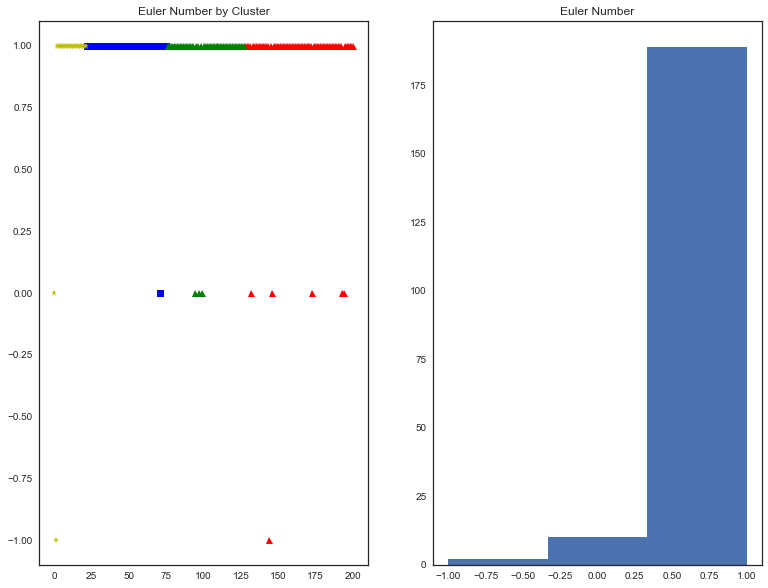

In [81]:
t = data[data['date']=='2017.11.23']['euler_number']
u = data[data['date']=='2017.11.17']['euler_number']
v = data[data['date']=='2017.11.22']['euler_number']
w = data[data['date']=='2017.11.09']['euler_number']

a = data[data['flow_rate']==1800]
a = a.groupby('euler_number').size().tolist()

b = data[data['flow_rate']==3600]
b = b.groupby('euler_number').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('euler_number').size().tolist()

print("Euler Number by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''plt.subplot(131)
plt.title("Euler Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])'''

plt.subplot(132)
plt.title("Euler Number by Cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.subplot(133)
plt.title("Euler Number")
plt.hist(data['euler_number'], bins=3)

plt.show()

Ratio of pixels in the region to pixels in the total bounding box. Computed as area / (rows * cols)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


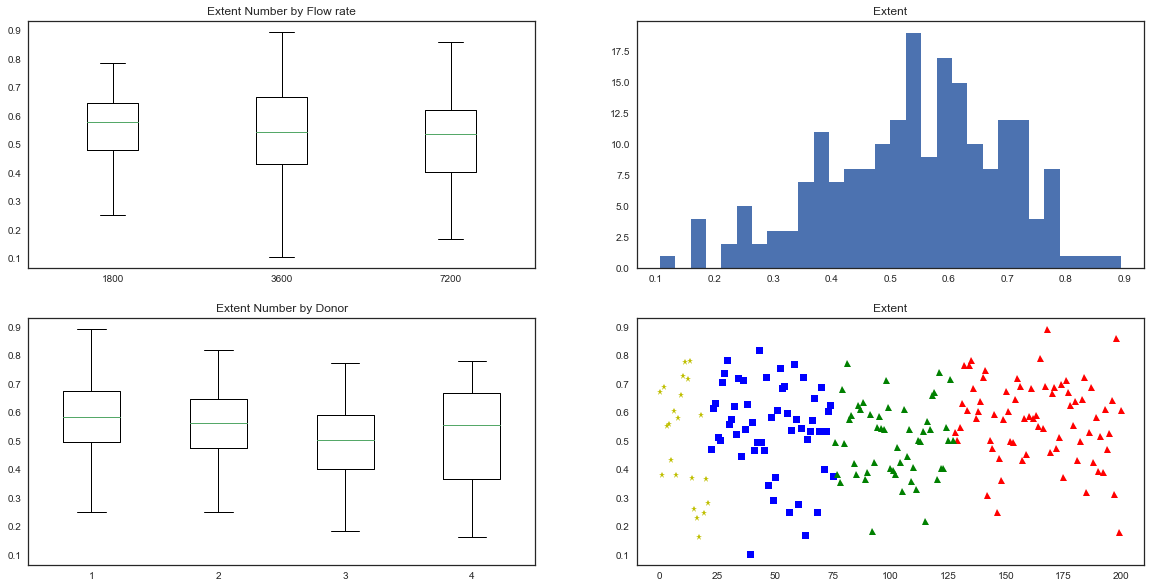

In [82]:
t = data[data['date']=='2017.11.23']['extent']
u = data[data['date']=='2017.11.17']['extent']
v = data[data['date']=='2017.11.22']['extent']
w = data[data['date']=='2017.11.09']['extent']

a = data[data['flow_rate']==1800]['extent']
b = data[data['flow_rate']==3600]['extent']
c = data[data['flow_rate']==7200]['extent']

plt.subplot(221)
plt.title("Extent Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Extent")
plt.hist(data['extent'], bins=30)

plt.subplot(223)
plt.title("Extent Number by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Extent")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


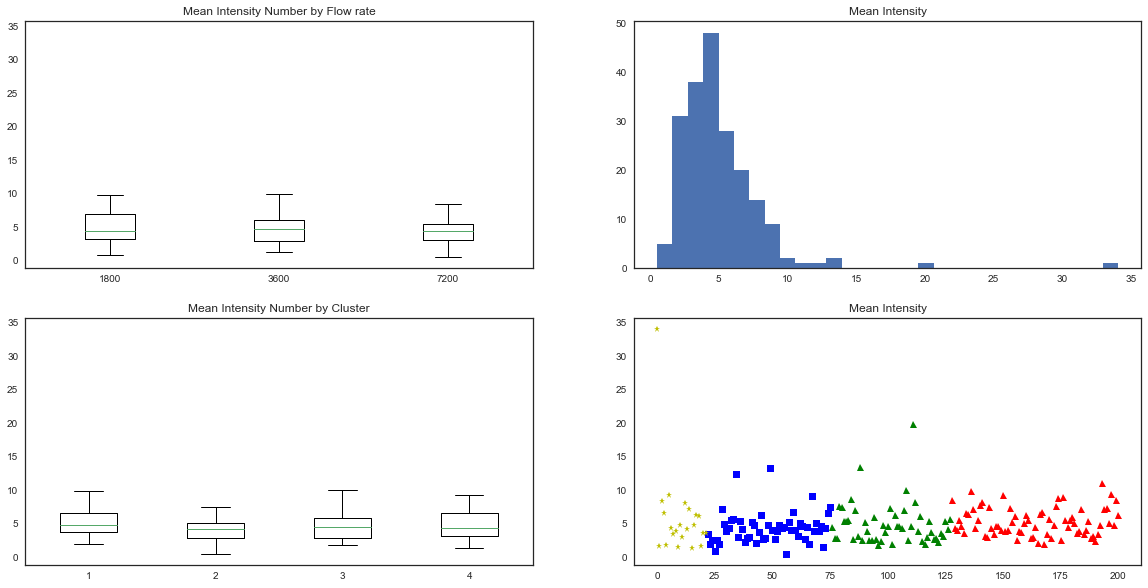

In [83]:
t = data[data['date']=='2017.11.23']['mean_intensity']
u = data[data['date']=='2017.11.17']['mean_intensity']
v = data[data['date']=='2017.11.22']['mean_intensity']
w = data[data['date']=='2017.11.09']['mean_intensity']

a = data[data['flow_rate']==1800]['mean_intensity']
b = data[data['flow_rate']==3600]['mean_intensity']
c = data[data['flow_rate']==7200]['mean_intensity']

plt.subplot(221)
plt.title("Mean Intensity Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Mean Intensity")
plt.hist(data['mean_intensity'], bins=30)

plt.subplot(223)
plt.title("Mean Intensity Number by Cluster")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Mean Intensity")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

Angle between the X-axis and the major axis of the ellipse that has the same second-moments as the region. Ranging from -pi/2 to pi/2 in counter-clockwise direction.

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


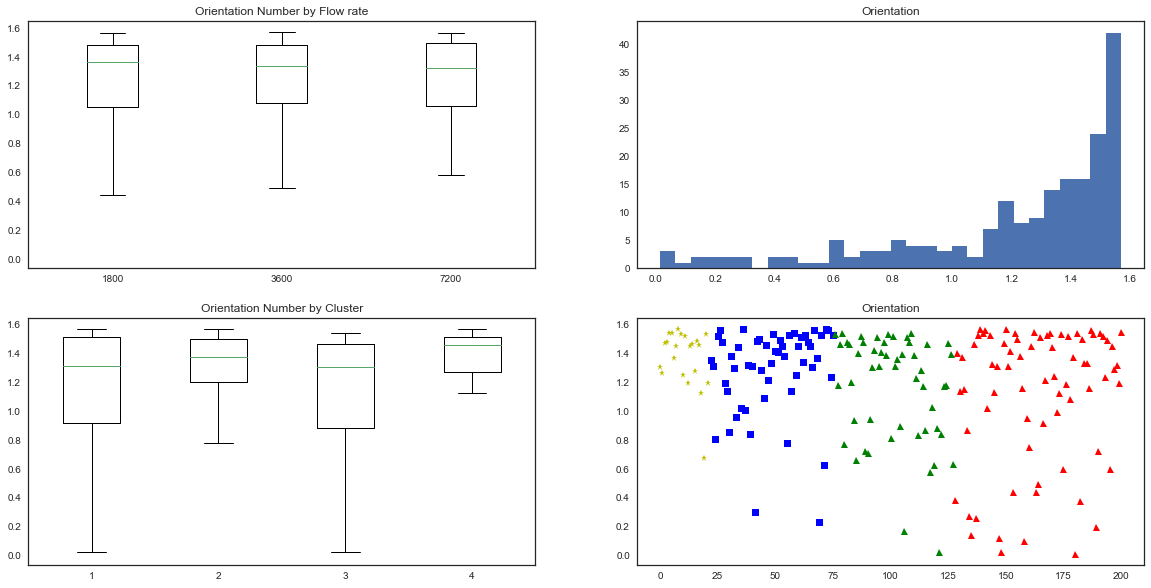

In [86]:
t = pd.DataFrame.abs(data[data['date']=='2017.11.23']['orientation'])
u = pd.DataFrame.abs(data[data['date']=='2017.11.17']['orientation'])
v = pd.DataFrame.abs(data[data['date']=='2017.11.22']['orientation'])
w = pd.DataFrame.abs(data[data['date']=='2017.11.09']['orientation'])

a = pd.DataFrame.abs(data[data['flow_rate']==1800]['orientation'])
b = pd.DataFrame.abs(data[data['flow_rate']==3600]['orientation'])
c = pd.DataFrame.abs(data[data['flow_rate']==7200]['orientation'])

plt.subplot(221)
plt.title("Orientation Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Orientation")
plt.hist(pd.DataFrame.abs(data['orientation']), bins=30)

plt.subplot(223)
plt.title("Orientation Number by Cluster")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Orientation")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


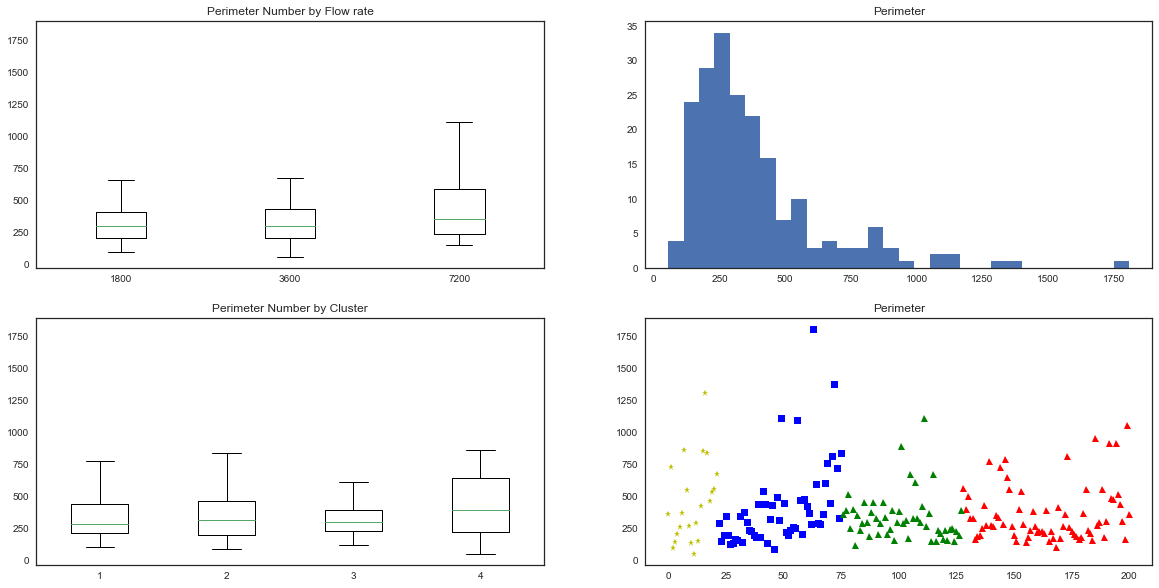

In [87]:
t = data[data['date']=='2017.11.23']['perimeter']
u = data[data['date']=='2017.11.17']['perimeter']
v = data[data['date']=='2017.11.22']['perimeter']
w = data[data['date']=='2017.11.09']['perimeter']

a = data[data['flow_rate']==1800]['perimeter']
b = data[data['flow_rate']==3600]['perimeter']
c = data[data['flow_rate']==7200]['perimeter']

plt.subplot(221)
plt.title("Perimeter Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Perimeter")
plt.hist(data['perimeter'], bins=30)

plt.subplot(223)
plt.title("Perimeter Number by Cluster")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Perimeter")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

## Mutual Information

In [88]:
print(feature_selection.mutual_info_classif(samples.as_matrix(), data['date']))
print(list(train_data.head()))

[0.03493076 0.00548075 0.         0.09380514 0.         0.01167916
 0.0134955  0.         0.         0.00361461 0.07319492 0.03288134
 0.01606521]
['peak_val', 'area', 'volume', 'eccentricity', 'euler_number', 'extent', 'mean_intensity', 'perimeter', 'cluster', 'num_peaks', 'sd', 'num_local_peaks']


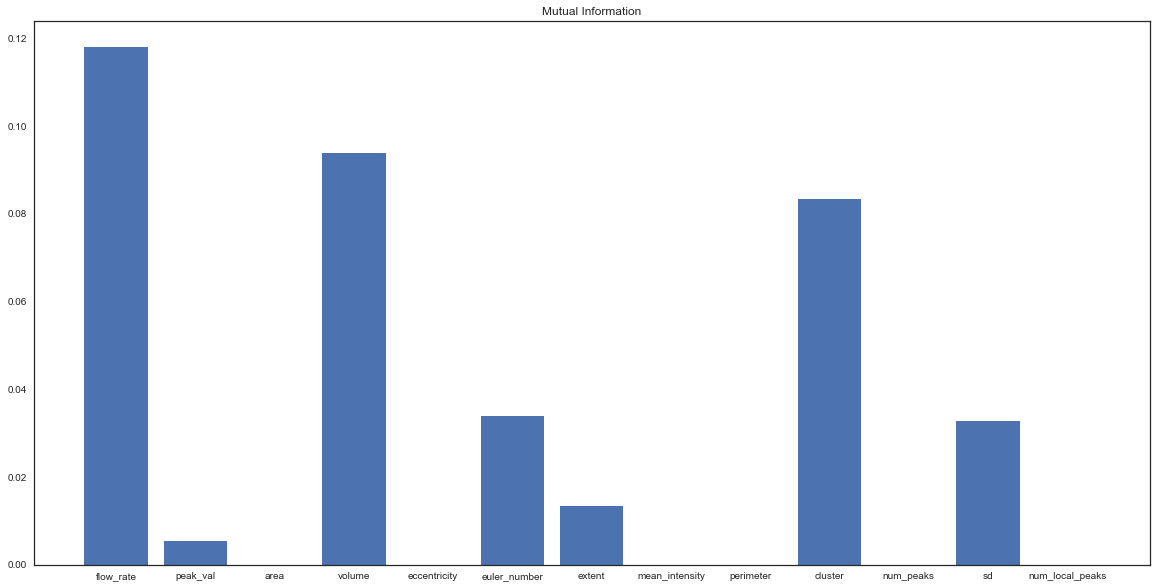

In [89]:
mi = feature_selection.mutual_info_classif(samples.as_matrix(), data['date'])
labels = list(samples.head())

x = np.arange(len(mi))

fig, ax = plt.subplots()
plt.title("Mutual Information")
plt.bar(x, mi)
plt.xticks(x, labels)

plt.show()

### Cluster sizes

### Comparison of Manifold Algorithms

Source: http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py

In [ ]:
n_neighbors = 50
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (len(points), n_neighbors), fontsize=14)

X = standardize
color = data['flow_rate']

''' ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72) '''

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca',n_iter=5000, random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

In [ ]:
perplexity = [5,10,30,50,100]

fig = plt.figure(figsize=(15, 8))
plt.suptitle("t-SNE Learning with %i points, %i neighbors by perplexity"
             % (len(points), n_neighbors), fontsize=14)

for i,p in enumerate(perplexity):
    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, perplexity=p, init='pca',n_iter=5000, random_state=0)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(251+i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("t-SNE (p:%d)" % (p))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

plt.show()